In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ..

/scratch/km817/iREC


In [4]:
import torch
import hamiltorch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

In [5]:
%matplotlib inline

In [6]:
hamiltorch.set_random_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
hamiltorch.__version__

'0.4.0.dev1'

In [8]:
from models.BNNs.DeterministicNN import Deterministic_NN

In [9]:
# create toy dataset
fs=16
torch.set_default_tensor_type(torch.DoubleTensor)
torch.manual_seed(20)
x = torch.cat([torch.Tensor(75).uniform_(-5, -2).sort()[0].reshape(-1, 1),
               torch.Tensor(50).uniform_(2, 5).sort()[0].reshape(-1, 1)])
i = 30
x_data = torch.cat([x[0:i - 15], x[i + 14:]])

# generate some data
alpha, beta, num_nodes = 1., 100., 2

# generate some data
data_generator_model = Deterministic_NN(alpha=alpha, beta=beta, num_nodes=num_nodes)
sampled_weights = data_generator_model.sample_weights_from_prior()
data_generator_model.make_weights_from_sample(sampled_weights)
y_data = data_generator_model(x_data).detach() + (
            1 / data_generator_model.likelihood_beta ** 0.5) * torch.randn_like(
    data_generator_model(x_data).detach())

xs = torch.linspace(-10, 10, 100)
ys = data_generator_model(xs).detach()

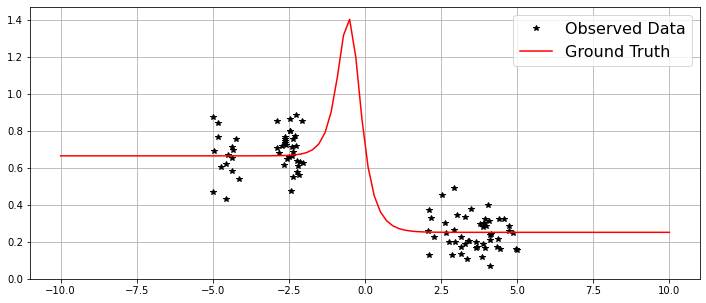

In [10]:
plt.figure(figsize=(12,5))
plt.plot(x_data,y_data, 'k*')
plt.plot(xs, ys, 'r')
plt.legend(['Observed Data', 'Ground Truth'], fontsize = fs)
plt.grid()
plt.show()

In [11]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if torch.cuda.is_available():
#     print(torch.cuda.get_device_name(0))

device  =torch.device('cpu')

class Net(nn.Module):
    def __init__(self, num_nodes: int = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, num_nodes)
        self.fc2 = nn.Linear(num_nodes, num_nodes)
        self.fc3 = nn.Linear(num_nodes, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x.view(-1, 1)))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net(num_nodes=num_nodes)

# MF-VI Approx

In [12]:
from models.BNNs.SimpleBBPBNN import SimpleBBPBNN, train_bnn
from models.BNNs.pyroBNN_local_reparam import BayesianNeuralNetwork
from pyro.infer.autoguide import AutoDiagonalNormal
import pyro
import pyro.distributions as dist

In [13]:
# create models
model = BayesianNeuralNetwork(prior_var=1./alpha, likelihood_var=1./beta, hidden_nodes=num_nodes)
guide = AutoDiagonalNormal(model)

from pyro.infer import SVI, TraceMeanField_ELBO

adam = pyro.optim.Adam({"lr": 0.005})
svi = SVI(model, guide, adam, loss=TraceMeanField_ELBO())

num_iterations = 10000
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 1000 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_data)))

guide.requires_grad_(False)

params = []
for name, value in pyro.get_param_store().items():
    params.append(pyro.param(name))

[iteration 0001] loss: 19.5381
[iteration 1001] loss: -0.3923
[iteration 2001] loss: -0.2473
[iteration 3001] loss: -0.6181
[iteration 4001] loss: -0.6050
[iteration 5001] loss: -0.6352
[iteration 6001] loss: -0.6161
[iteration 7001] loss: -0.6522
[iteration 8001] loss: -0.6909
[iteration 9001] loss: -0.6906


/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/pyro/distributions/torch_patch.py:81: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  return torch.stack([v.symeig(eigenvectors=False)[0][:1] > 0.0


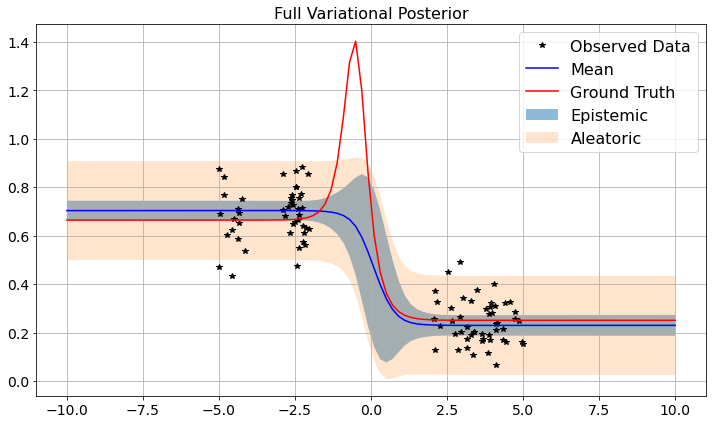

In [14]:
model_loss = 'regression'

# Effect of tau
tau = alpha # Prior Precision
tau_out = beta # Output Precision

tau_list = []
for w in net.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
tau_list = torch.tensor(tau_list).to(device)

mean, stds = params

variational_posterior = dist.MultivariateNormal(loc=mean, covariance_matrix=torch.diag(stds ** 2))

variational_samples = variational_posterior.sample((1000,))
pred_list, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=variational_samples,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

# plot the fit
fs = 16

m = pred_list.mean(0).to('cpu')
s = pred_list.std(0).to('cpu')
s_al = (pred_list.var(0).to('cpu') + tau_out ** -1) ** 0.5

f, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(xs.numpy(), m.numpy(), 'b', rasterized=True)
ax.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)
# Shade between the lower and upper confidence bounds
ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title('Full Variational Posterior', fontsize=fs)

plt.tight_layout()
# plt.savefig('plots/full_hmc.pdf', rasterized=True)
    
plt.show()

# Compress some weights with variational scheme

In [15]:
#### sample weights with compression algorithm
from rec.beamsearch.Coders.Encoder_Variational import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.VariationalPosterior import VariationalPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.OptimisingVars.VariationalOptimiser import VariationalOptimiser
from tqdm.notebook import trange
coding_sampler = CodingSampler
auxiliary_posterior = VariationalPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.



compute_params_enc =  encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)

n_auxiliaries = compute_params_enc.n_auxiliary
kl_q_p = compute_params_enc.total_kl
var_opt = VariationalOptimiser(compute_params_enc.target, omega, n_auxiliaries, kl_q_p, n_trajectories=16, total_var=1./alpha)
aux_vars = var_opt.run_optimiser(epochs=1000)

The mean loss is 5.84301. The mean KL is: 5.84411: 100%|██████████| 1000/1000 [02:00<00:00,  8.28it/s]


In [19]:
initial_seed = 0
beamwidth = 1
epsilon = 0.

compressed_weights = []
num_compressed_samples = 250
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    w, idx = encoder.run_encoder()

    compressed_weights.append(w[0])

  0%|          | 0/250 [00:00<?, ?it/s]

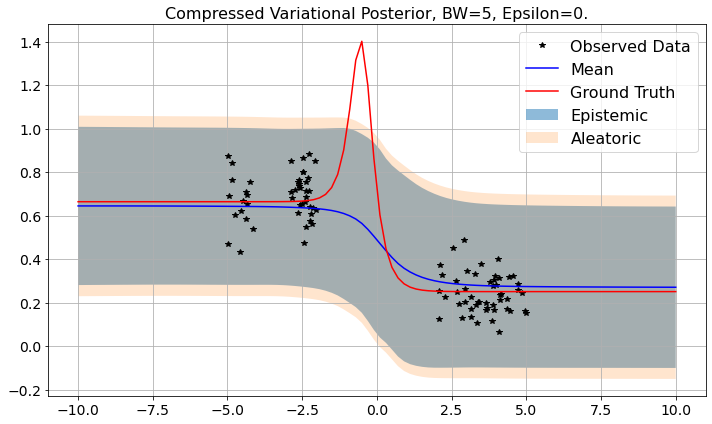

In [20]:
pred_list, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

# plot the fit
fs = 16

m = pred_list.mean(0).to('cpu')
s = pred_list.std(0).to('cpu')
s_al = (pred_list.var(0).to('cpu') + tau_out ** -1) ** 0.5

f, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(xs.numpy(), m.numpy(), 'b', rasterized=True)
ax.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)
# Shade between the lower and upper confidence bounds
ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title('Compressed Variational Posterior, BW=5, Epsilon=0.', fontsize=fs)

plt.tight_layout()
# plt.savefig('plots/full_hmc.pdf', rasterized=True)
    
plt.show()

In [22]:
initial_seed = 0
beamwidth = 1
epsilon = 0.1

compressed_weights = []
num_compressed_samples = 250
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    w, idx = encoder.run_encoder()

    compressed_weights.append(w[0])

  0%|          | 0/250 [00:00<?, ?it/s]

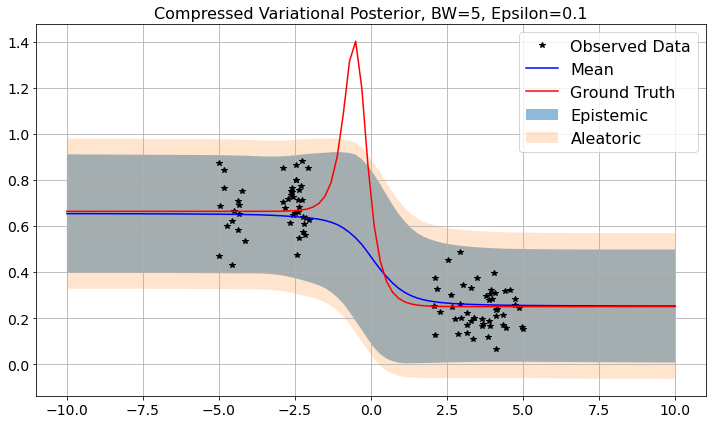

In [23]:
pred_list, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

# plot the fit
fs = 16

m = pred_list.mean(0).to('cpu')
s = pred_list.std(0).to('cpu')
s_al = (pred_list.var(0).to('cpu') + tau_out ** -1) ** 0.5

f, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(xs.numpy(), m.numpy(), 'b', rasterized=True)
ax.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)
# Shade between the lower and upper confidence bounds
ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title('Compressed Variational Posterior, BW=5, Epsilon=0.1', fontsize=fs)

plt.tight_layout()
# plt.savefig('plots/full_hmc.pdf', rasterized=True)
    
plt.show()

In [24]:
initial_seed = 0
beamwidth = 1
epsilon = 0.2

compressed_weights = []
num_compressed_samples = 250
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    w, idx = encoder.run_encoder()

    compressed_weights.append(w[0])

  0%|          | 0/250 [00:00<?, ?it/s]

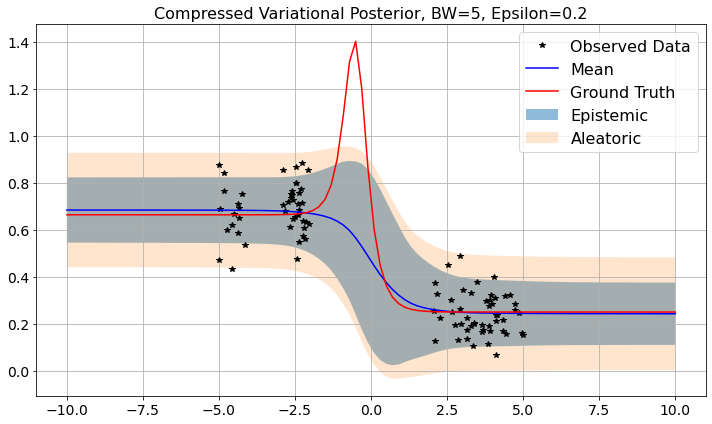

In [25]:
pred_list, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

# plot the fit
fs = 16

m = pred_list.mean(0).to('cpu')
s = pred_list.std(0).to('cpu')
s_al = (pred_list.var(0).to('cpu') + tau_out ** -1) ** 0.5

f, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(xs.numpy(), m.numpy(), 'b', rasterized=True)
ax.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)
# Shade between the lower and upper confidence bounds
ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title('Compressed Variational Posterior, BW=5, Epsilon=0.2', fontsize=fs)

plt.tight_layout()
# plt.savefig('plots/full_hmc.pdf', rasterized=True)
    
plt.show()

# Thinning samples

In [26]:
log_probs = torch.empty([0])
for w in compressed_weights:
    log_probs = torch.cat([log_probs, variational_posterior.log_prob(w)[None]])

In [27]:
torch.topk(log_probs, k=10)

torch.return_types.topk(
values=tensor([5.1392, 4.9230, 4.5972, 4.3352, 3.9056, 3.7974, 3.6343, 3.5980, 3.5016,
        3.1899]),
indices=tensor([ 67, 156,  33,  46, 218, 154,  92,  45, 165, 100]))

In [28]:
vals, idxs = torch.topk(log_probs, 30)

In [29]:
thinned_weights = []
for i in idxs:
    j = int(i)
    thinned_weights.append(compressed_weights[j])

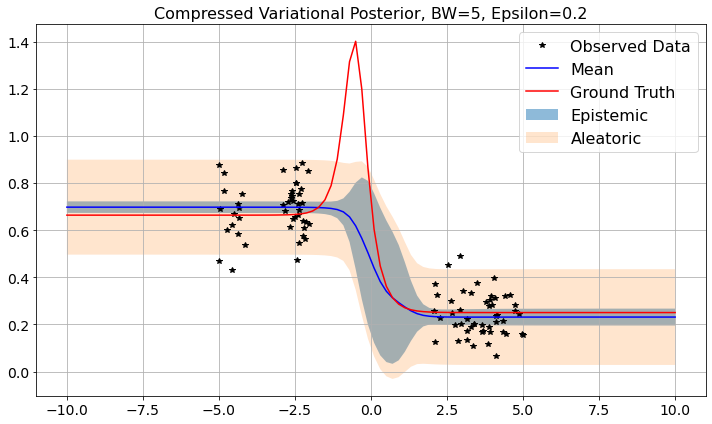

In [30]:
pred_list, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=thinned_weights,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

# plot the fit
fs = 16

m = pred_list.mean(0).to('cpu')
s = pred_list.std(0).to('cpu')
s_al = (pred_list.var(0).to('cpu') + tau_out ** -1) ** 0.5

f, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(xs.numpy(), m.numpy(), 'b', rasterized=True)
ax.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)
# Shade between the lower and upper confidence bounds
ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title('Compressed Variational Posterior, BW=5, Epsilon=0.2', fontsize=fs)

plt.tight_layout()
# plt.savefig('plots/full_hmc.pdf', rasterized=True)
    
plt.show()

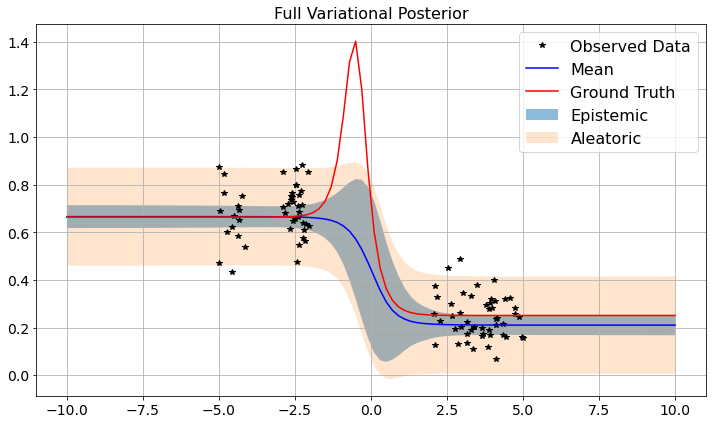

In [75]:
model_loss = 'regression'

# Effect of tau
tau = alpha # Prior Precision
tau_out = beta # Output Precision

tau_list = []
for w in net.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
tau_list = torch.tensor(tau_list).to(device)

mean, stds = params

variational_posterior = dist.MultivariateNormal(loc=mean, covariance_matrix=torch.diag(stds ** 2))

variational_samples = variational_posterior.sample((1000,))
pred_list, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=variational_samples,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

# plot the fit
fs = 16

m = pred_list.mean(0).to('cpu')
s = pred_list.std(0).to('cpu')
s_al = (pred_list.var(0).to('cpu') + tau_out ** -1) ** 0.5

f, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(xs.numpy(), m.numpy(), 'b', rasterized=True)
ax.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)
# Shade between the lower and upper confidence bounds
ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title('Full Variational Posterior', fontsize=fs)

plt.tight_layout()
# plt.savefig('plots/full_hmc.pdf', rasterized=True)
    
plt.show()